# Matrix Conditioning and Uncertainties

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../"*2)
import warnings
warnings.filterwarnings('ignore')

In [59]:
from quantumnetworks import MultiModeSystem, plot_full_evolution
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

### Single Mode System

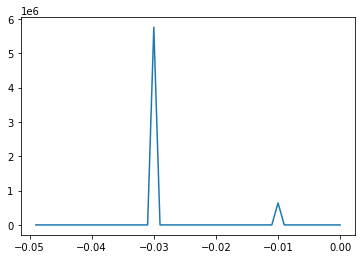

In [126]:
omegas = [6]
kappas = [0.01]
gammas = [0.0]
kerrList = -1*np.arange(0, 0.05, 0.001) # [-1.5] #
couplings = []

conds = []
op = np.array([10, 0])

for kerr in kerrList:
    
    kerrs = [kerr]
    sys = MultiModeSystem(params={"omegas":omegas, "kappas":kappas,"gammas":gammas,"kerrs":kerrs,"couplings":couplings})

    plot_evolution = False
    if plot_evolution:
        x_0 = np.array([1,0])
        ts = np.linspace(0, 10, 1001)
        X = sys.forward_euler(x_0, ts)
        fig, ax = plot_full_evolution(X, ts, labels=["$q_a$","$p_a$"])
        ax.legend()
        
    
    conds.append(np.linalg.cond(sys.A+sys.Jf_nl(op)))

# Plot condition number
plt.plot(kerrList, conds)
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

In [116]:
A = sys.A
A_inv = np.linalg.inv(sys.A)
A_nl = sys.A+sys.Jf_nl(op)
A_nl_inv = np.linalg.inv(A_nl)


k_A = np.linalg.cond(A)
k_A_nl_np = np.linalg.cond(A_nl)
k_A_nl = np.sqrt(np.max(np.linalg.eigvals(np.transpose(A_nl) @ A_nl))) * \
np.sqrt(np.max(np.linalg.eigvals(np.transpose(A_nl_inv) @ A_nl_inv)))


print("Condition Numbers")
print(f"c(A) = {k_A:2e}") 

print(f"c(A_nl) = {k_A_nl:2e}")
print(f"c(A_nl) = {k_A_nl_np:2e} (numpy)")

Condition Numbers
c(A) = 1.000000e+00
c(A_nl) = 6.400000e+09
c(A_nl) = 6.400000e+09 (numpy)


In [117]:
A_nl

array([[-0.00005,  4.     ],
       [ 0.     , -0.00005]])

### Double Mode System

In [60]:
# double mode system
omegas = [1,2]
kappas = [0.001,0.005]
gammas = [0.002,0.002]
kerrs = [0.001, 0.001]
couplings = [[0,1,0.002]]
sys = MultiModeSystem(params={"omegas":omegas, "kappas":kappas, "gammas":gammas, "kerrs": kerrs, "couplings":couplings})

In [62]:
print(np.around(sys.A, decimals=4))

np.linalg.cond(A)

[[-0.0015  1.      0.      0.002 ]
 [-1.     -0.0015 -0.002   0.    ]
 [ 0.      0.002  -0.0035  2.    ]
 [-0.002   0.     -2.     -0.0035]]


1.0000000000000002

### 3 Mode System

In [ ]:
# 3 mode system
omegas = [1,2,1]
kappas = [0.001,0.005,0.001]
gammas = [0.002,0.002,0.002]
kerrs = [0.001, 0.001, 0.001]
couplings = [[0,1,0.002],[1,2,0.002]]
sys = MultiModeSystem(params={"omegas":omegas, "kappas":kappas, "gammas":gammas, "kerrs":kerrs, "couplings":couplings})
print(np.around(sys.A, decimals=4))
# x_0 = np.array([1,0,0,1])
# ts = np.linspace(0, 10, 1001)
# X = sys.forward_euler(x_0, ts)
# fig, ax = plot_full_evolution(X, ts, labels=["$q_a$","$p_a$","$q_b$","$p_b$"])
# ax.legend()

## Notes and Observations

- For linear systems (i.e. kerr K = 0), the matrix A is always well conditioned by construction and c(A) ~ 1. 


- For non-linear SingleModeSystem, we need **negative** kerr (K < 0) in order to be able to find a singular operating point. 
    - If loss is nearly zero (i.e. κa ~ 0 and γa = 0), then the terms (κa + γa)/2 in the diagonals of A_nl nearly vanish. Then, for certain values of kerr K and operating point (q0, p0), the rows/columns become linearly dependent. 
    - E.g. if (q0, p0) = (1, 0), then we find c(A_nl) ~ 1e9 (i.e. _gets very large_) near K = -ωa / 6, and then again c(A_nl) ~ 1e10 near K = -ωa / 2